# facial landmarks (478 3-dimensional face landmarks)

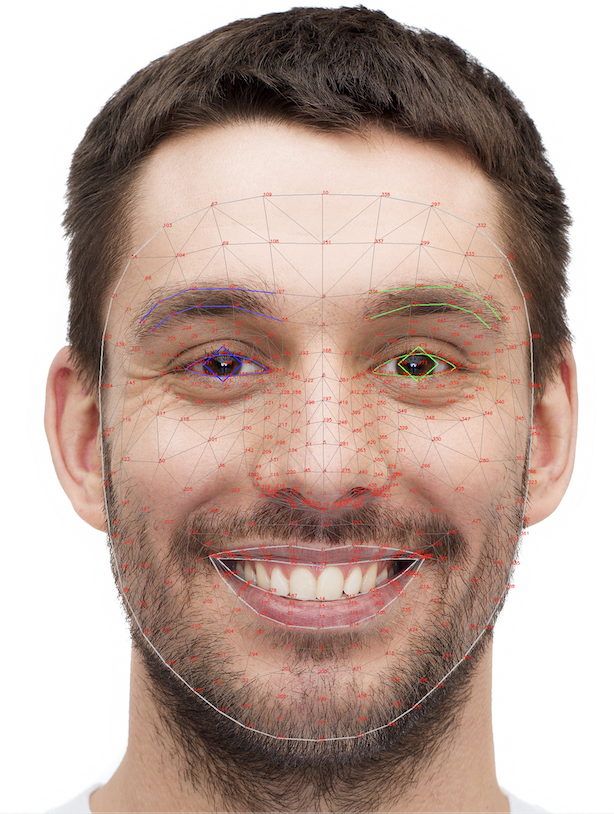

# Eyes Blink Detector and Counter with MediaPipe

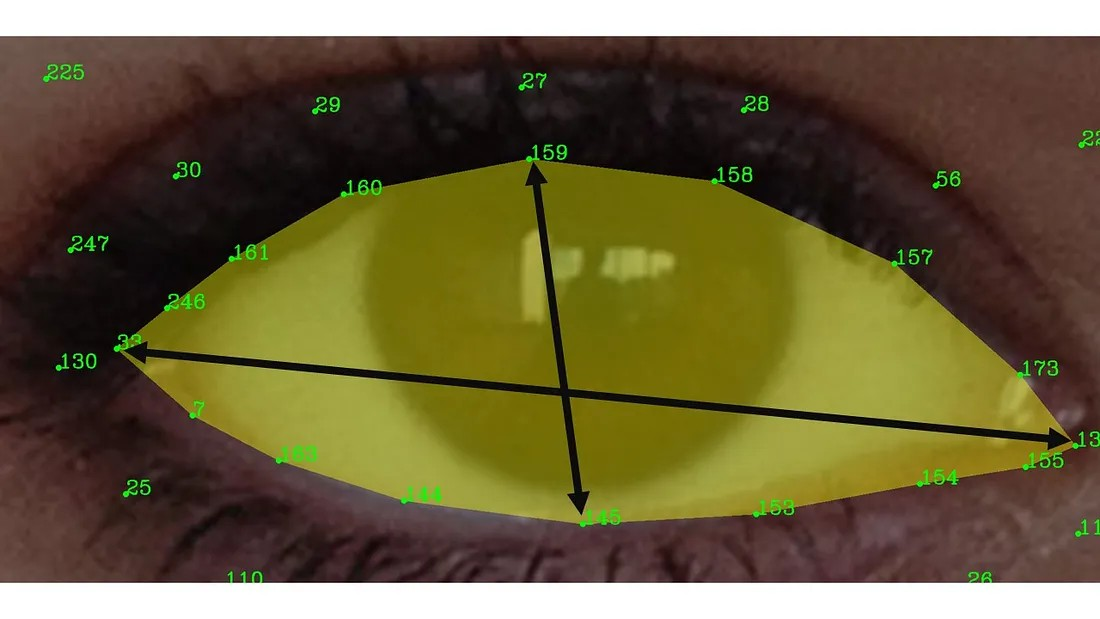
  

# Right Eye Keypoints

In [ ]:
import cv2 as cv
import mediapipe as mp
import time
import utils,math
import numpy as np
# variables 
frame_counter =0
CEF_COUNTER =0
TOTAL_BLINKS =0
# constants
CLOSED_EYES_FRAME =3
FONTS =cv.FONT_HERSHEY_COMPLEX

# face bounder indices 
FACE_OVAL=[ 10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162, 21, 54, 103,67, 109]

# lips indices for Landmarks
LIPS=[ 61, 146, 91, 181, 84, 17, 314, 405, 321, 375,291, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95,185, 40, 39, 37,0 ,267 ,269 ,270 ,409, 415, 310, 311, 312, 13, 82, 81, 42, 183, 78 ]
LOWER_LIPS =[61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95]
UPPER_LIPS=[ 185, 40, 39, 37,0 ,267 ,269 ,270 ,409, 415, 310, 311, 312, 13, 82, 81, 42, 183, 78] 
# Left eyes indices 
LEFT_EYE =[ 362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385,384, 398 ]
LEFT_EYEBROW =[ 336, 296, 334, 293, 300, 276, 283, 282, 295, 285 ]

# right eyes indices
RIGHT_EYE=[ 33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161 , 246 ]  
RIGHT_EYEBROW=[ 70, 63, 105, 66, 107, 55, 65, 52, 53, 46 ]

map_face_mesh = mp.solutions.face_mesh
# camera object 
camera = cv.VideoCapture(0)
# landmark detection function 
def landmarksDetection(img, results, draw=False):
    img_height, img_width= img.shape[:2]
    # list[(x,y), (x,y)....]
    mesh_coord = [(int(point.x * img_width), int(point.y * img_height)) for point in results.multi_face_landmarks[0].landmark]
    if draw :
        [cv.circle(img, p, 2, (0,255,0), -1) for p in mesh_coord]

    # returning the list of tuples for each landmarks 
    return mesh_coord

# Euclaidean distance 
def euclaideanDistance(point, point1):
    x, y = point
    x1, y1 = point1
    distance = math.sqrt((x1 - x)**2 + (y1 - y)**2)
    return distance

# Blinking Ratio
def blinkRatio(img, landmarks, right_indices, left_indices):
    # Right eyes 
    # horizontal line 
    rh_right = landmarks[right_indices[0]]
    rh_left = landmarks[right_indices[8]]
    # vertical line 
    rv_top = landmarks[right_indices[12]]
    rv_bottom = landmarks[right_indices[4]]
    # draw lines on right eyes 
    # cv.line(img, rh_right, rh_left, utils.GREEN, 2)
    # cv.line(img, rv_top, rv_bottom, utils.WHITE, 2)

    # LEFT_EYE 
    # horizontal line 
    lh_right = landmarks[left_indices[0]]
    lh_left = landmarks[left_indices[8]]

    # vertical line 
    lv_top = landmarks[left_indices[12]]
    lv_bottom = landmarks[left_indices[4]]

    rhDistance = euclaideanDistance(rh_right, rh_left)
    rvDistance = euclaideanDistance(rv_top, rv_bottom)

    lvDistance = euclaideanDistance(lv_top, lv_bottom)
    lhDistance = euclaideanDistance(lh_right, lh_left)

    reRatio = rhDistance/rvDistance
    leRatio = lhDistance/lvDistance

    ratio = (reRatio+leRatio)/2
    return ratio 



with map_face_mesh.FaceMesh(min_detection_confidence =0.5, min_tracking_confidence=0.5) as face_mesh:
   
    # starting time here 
    start_time = time.time()
    # starting Video loop here.
    while True:
        frame_counter +=1 # frame counter
        ret, frame = camera.read() # getting frame from camera 
        if not ret: 
            break # no more frames break
        #  resizing frame
        frame = cv.resize(frame, None, fx=1.5, fy=1.5, interpolation=cv.INTER_CUBIC)
        frame_height, frame_width= frame.shape[:2]
        rgb_frame = cv.cvtColor(frame, cv.COLOR_RGB2BGR)
        results  = face_mesh.process(rgb_frame)
        if results.multi_face_landmarks:
            mesh_coords = landmarksDetection(frame, results, False)
            ratio = blinkRatio(frame, mesh_coords, RIGHT_EYE, LEFT_EYE)
            # cv.putText(frame, f'ratio {ratio}', (100, 100), FONTS, 1.0, utils.GREEN, 2)
            utils.colorBackgroundText(frame,  f'Ratio : {round(ratio,2)}', FONTS, 0.7, (30,100),2, utils.PINK, utils.YELLOW)

            if ratio >3.5:
                CEF_COUNTER +=1
                # cv.putText(frame, 'Blink', (200, 50), FONTS, 1.3, utils.PINK, 2)
                utils.colorBackgroundText(frame,  f'Blink', FONTS, 1.7, (int(frame_height/2), 100), 2, utils.YELLOW, pad_x=6, pad_y=6, )

            else:
                if CEF_COUNTER>CLOSED_EYES_FRAME:
                    TOTAL_BLINKS +=1
                    CEF_COUNTER =0
            # cv.putText(frame, f'Total Blinks: {TOTAL_BLINKS}', (100, 150), FONTS, 0.6, utils.GREEN, 2)
            utils.colorBackgroundText(frame,  f'Total Blinks: {TOTAL_BLINKS}', FONTS, 0.7, (30,150),2)
            
            cv.polylines(frame,  [np.array([mesh_coords[p] for p in LEFT_EYE ], dtype=np.int32)], True, utils.GREEN, 1, cv.LINE_AA)
            cv.polylines(frame,  [np.array([mesh_coords[p] for p in RIGHT_EYE ], dtype=np.int32)], True, utils.GREEN, 1, cv.LINE_AA)



        # calculating  frame per seconds FPS
        end_time = time.time()-start_time
        fps = frame_counter/end_time

        frame =utils.textWithBackground(frame,f'FPS: {round(fps,1)}',FONTS, 1.0, (30, 50), bgOpacity=0.9, textThickness=2)
        # writing image for thumbnail drawing shape
        # cv.imwrite(f'img/frame_{frame_counter}.png', frame)
        cv.imshow('frame', frame)
        key = cv.waitKey(2)
        if key==ord('q') or key ==ord('Q'):
            break
    cv.destroyAllWindows()
    camera.release()